# SegMate Demo Notebook

Welcome to the SegMate demo notebook! In this notebook, we will showcase the capabilities of SegMate, a Segment Anything Model Toolkit developed by AI Engineering team at Vector Institute.

## SegMate: A Segment Anything Model Toolkit

SegMate is a powerful toolkit that utilizes the Segment Anything Model (SAM) developed by Meta AI. SAM is a promptable segmentation system capable of accurately "cutting out" any object from an image with just a single click. It exhibits zero-shot generalization to unfamiliar objects and images, eliminating the need for additional training.

## SAM Architecture

SAM utilizes a sophisticated architecture comprising three key components: the image encoder, the prompt encoder, and the mask decoder.

- **Image Encoder**: Captures essential features from the input image, extracting high-level representations that encode relevant information about objects and their context. This step allows SAM to understand the visual content of the image.

- **Prompt Encoder**: Processes user-provided prompts, such as bounding boxes, points, or text, and transforms them into meaningful representations. These representations guide SAM to understand the desired object to be segmented.

- **Mask Decoder**: Generates precise segmentation masks by leveraging the encoded information from both the image encoder and the prompt encoder. It efficiently processes the features and produces detailed object boundaries, enabling near real-time segmentation results.

## SegMate Features

- API for easy inference with SAM, supporting bounding box, points, and text prompts.
- Automatic masking without the need for prompts.
- API for zero-shot image segmentation with Grounding Dino using text prompts.
- API for finetuning SAM on custom datasets.

Now, let's dive into the demo and explore the powerful capabilities of SegMate!


Let's start by importing the necessary libraries:

In [1]:
import sys
import os

# Get the parent directory (main repository directory)
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

In [2]:
import sys
print(sys.path)

['/ssd005/home/aditima/environment_project/SAT_SAM/example', '/pkgs/python-3.9.10/lib/python39.zip', '/pkgs/python-3.9.10/lib/python3.9', '/pkgs/python-3.9.10/lib/python3.9/lib-dynload', '', '/scratch/ssd004/scratch/aditima/segmate/lib/python3.9/site-packages', '/ssd005/home/aditima/environment_project/SAT_SAM']


In [3]:
import torch
import numpy as np

from segmate.segmate import SegMate
from segmate.object_detector import GroundingDINO, OvSeg
import segmate.utils as utils

/scratch/ssd004/scratch/aditima/segmate/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


### Initializing SegMate

To start using SegMate, we need to create an instance of the SegMate class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_b` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.
- `object_detector`: Optional parameter that allows you to provide a custom object detector when you want to use the model with text prompt. If not specified, the default object detector is `None`. You can always add the `object_detector` later.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [4]:
sm = SegMate(model_type='vit_b', checkpoint='../../sam_vit_b.pth', device='cuda', object_detector=None)

In [10]:
od = OvSeg()
sm.set_object_detector(od)

Loading config ../ov_seg/configs/ovseg_swinB_vitL_demo.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [11]:
sm.object_detector.model_name

'ovseg'

In [7]:
image_path='../example/images/building.png'

img = utils.read_image_ovseg(image_path, format="BGR")

<class 'PIL.PngImagePlugin.PngImageFile'>


Using ovseg Object Detector


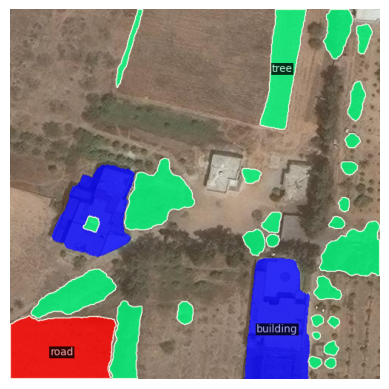

In [12]:
sm.segment(img, text_prompt=[['building', 'tree', 'road'], None, None])

In [7]:
import glob
import multiprocessing as mp
import os
import time
import cv2
import tqdm

# import ov_seg

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from ov_seg.open_vocab_seg import add_ovseg_config
from ov_seg.open_vocab_seg.utils import VisualizationDemo, SAMVisualizationDemo

import matplotlib.pyplot as plt

In [8]:
def setup_cfg(config_file, opts):
    # load config from file and command-line arguments
    cfg = get_cfg()
    # for poly lr schedule
    add_deeplab_config(cfg)
    add_ovseg_config(cfg)
    cfg.merge_from_file(config_file)
    cfg.merge_from_list(opts)
    cfg.freeze()
    return cfg


def detectron_demo(config_file, input_path, class_names=None, output_path=None, opts=[]):

    cfg = setup_cfg(config_file, opts)

    demo = VisualizationDemo(cfg)
    # use PIL, to be consistent with evaluation
    img = utils.read_image_ovseg(input_path, format="BGR")
    
    predictions, visualized_output = demo.run_on_image(img, class_names)

    plt.imshow(visualized_output.get_image())
    plt.axis('off')
    plt.show()
    
def detectron_demo_sam(config_file, input_path, class_names=None, output_path=None, opts=[]):

    cfg = setup_cfg(config_file, opts)
    
    granularity=0.8

    demo = SAMVisualizationDemo(cfg, granularity, '../../sam_vit_l_0b3195.pth', '../../ovseg_clip_l_9a1909.pth')
    # use PIL, to be consistent with evaluation
    img = utils.read_image_ovseg(input_path, format="BGR")
    predictions, visualized_output = demo.run_on_image(img, class_names)

    plt.imshow(visualized_output.get_image())
    plt.axis('off')
    plt.show()

In [9]:
config_file = "../ov_seg/configs/ovseg_swinB_vitL_demo.yaml"
input_paths = '../ov_seg/resources/demo_samples/bridge.jpg'  # List of input image paths
class_names = ['bridge', 'water']  # List of user-defined class_names
output_path = "./pred/bridge_results_ovseg.jpg"  # Output directory path
opts = ["MODEL.WEIGHTS", '../../ovseg_swinbase_vitL14_ft_mpt.pth']  # Additional config options as key-value pairs

<class 'detectron2.config.config.CfgNode'>


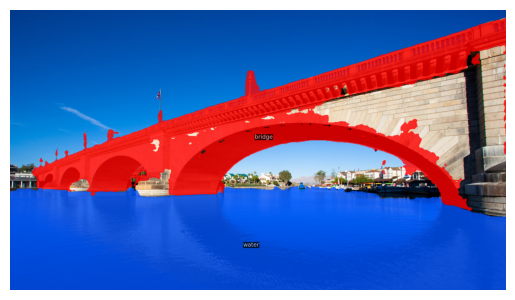

In [11]:
detectron_demo(config_file, input_paths, class_names, output_path, opts)

<class 'numpy.ndarray'>


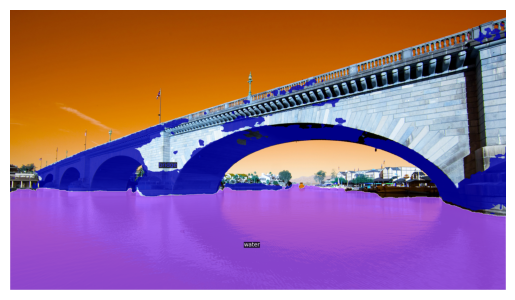

In [23]:
detectron_demo(config_file, input_paths, class_names, output_path, opts)

Loading config ../ov_seg/configs/ovseg_swinB_vitL_demo.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


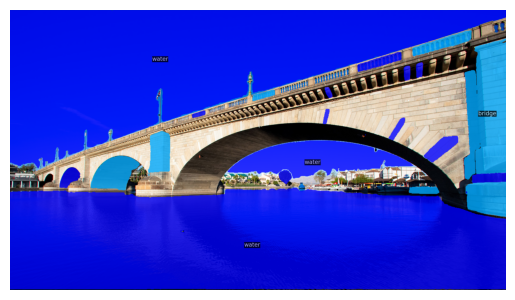

In [7]:
detectron_demo_sam(config_file, input_paths, class_names, output_path, opts)

### Adding Object Detector for Text Prompts

If you want to utilize text prompts for segmentation tasks, SegMate provides the ability to incorporate an object detector that processes the text and outputs the corresponding bounding boxes for the specified objects.

To enable text prompts and generate bounding boxes, follow these steps:

1. Create an instance of the object detector specifically designed for text prompts.
2. Add the text object detector to the SegMate toolkit using the `set_object_detector()` method.

Let's take a look at the code snippet:

In [8]:
od = GroundingDINO()
sm.set_object_detector(od)

/scratch/ssd004/scratch/aditima/segmate/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Loading and Showing an Image

Before we proceed with the segmentation, let's start by loading and displaying an image using some basic functions provided by SegMate.

To load an image, we use the `load_image()` function from the `utils` module. Here, we specify the path to the image file using the `image_path` parameter. The loaded image is stored in the `image` variable.

After loading the image, we can use the `show_image()` function from the `utils` module to display it. The `show_image()` function takes the loaded image as a parameter and presents it in a graphical format.

Let's see how this is done:

In [16]:
image = utils.load_image(image_path='../example/images/building.png')

In [10]:
image.shape

(500, 500, 3)

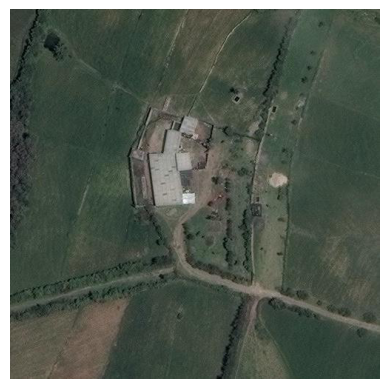

In [11]:
utils.show_image(image=image)

### Using Building Image Segmentation Dataset

In this section, we will demonstrate how to load and utilize the Building Image Segmentation dataset, which is available in the HuggingFace datasets library. We will load the mini version of the dataset and retrieve the bounding box, segmentation mask, and image of a sample from the training set.

To begin, we import the necessary libraries and load the dataset using the `load_dataset()` function from the HuggingFace🤗 datasets library:

In [45]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

print(len(dataset['train']))

6764


Next, we retrieve a sample from the training set using the dataset's indexing notation. Here, we retrieve the second sample (index 1):

The sample variable now contains the image, bounding box information, and segmentation mask for the selected sample.

In [8]:
sample = dataset['train'][1]
image = sample["image"]
bbox = sample['objects']['bbox']
seg_mask = sample['objects']['segmentation']

To visualize the image, bounding boxes, and segmentation mask, we can utilize the utility functions provided by SegMate. First, we display the image using the `show_image()` function:

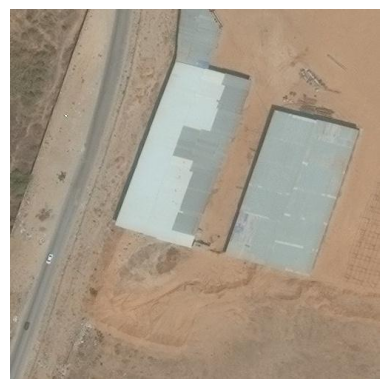

In [9]:
utils.show_image(image=image)

Next, we show the bounding boxes on the image using the `show_bounding_boxes()` function:

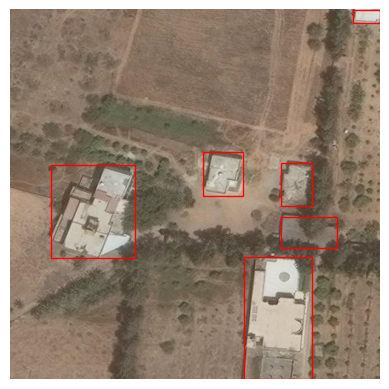

In [16]:
utils.show_bounding_boxes(image=image, bounding_boxes=bbox)

In [17]:
# image_path='../example/images/building.png'

img = utils.read_image_ovseg(image, format="BGR")

Using ovseg Object Detector


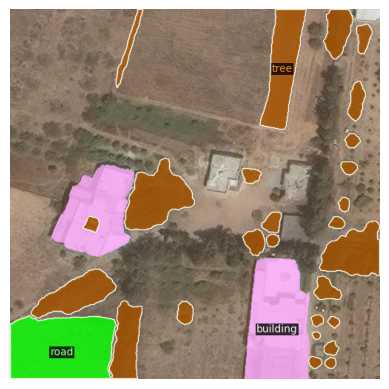

In [18]:
sm.segment(img, text_prompt=[['building', 'tree', 'road'], None, None])

Additionally, we can generate a binary segmentation mask from the segmentation label and display it using the `get_segmentation_mask()` and `show_image()` functions:

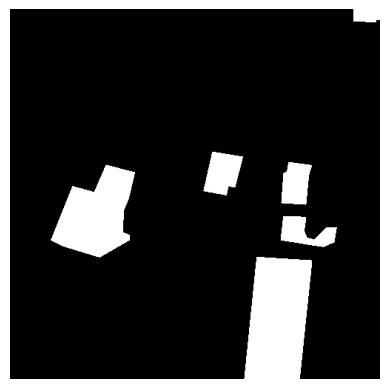

In [18]:
binary_mask = utils.get_segmentation_mask(segmentation_label=seg_mask, size=500)
utils.show_image(binary_mask.reshape(500, 500))

### Automatic Mask Generation with SAM

In this section, we will demonstrate how to utilize the automatic mask generation feature of SAM without using any prompts. This feature allows SAM to generate segmentation masks automatically based on the input image.

To generate the masks automatically, we will utilize the `auto_segment()` method provided by the SegMate toolkit. This method takes the image as input and returns the generated masks.

Let's take a look at the code snippet:

In [19]:
masks = sm.auto_segment(image=np.array(image))

In this section, we will demonstrate how to visualize the masks generated by SAM's automatic mask generation feature. After obtaining the masks using the `auto_segment()` method, we can utilize the `visualize_automask()` function provided by the SegMate toolkit to visualize the generated masks overlaid on the input image.

Let's take a look at the code snippet:

In [ ]:
sm.visualize_automask(image=np.array(image), masks=masks)

### Mask Generation using Bounding Boxes

In this section, we will demonstrate how to utilize bounding boxes to generate masks using the SegMate toolkit. By providing bounding box information as prompts, SAM can generate masks specifically for the objects defined by these boxes.

To generate masks using bounding boxes, we will use the `segment()` method provided by the SegMate toolkit (`sm`). This method takes the input image and bounding box prompts as inputs and returns the corresponding segmentation masks.

Note: The reason we use `utils.convert_coco_to_sam(bbox)` is to ensure that the bounding boxes are in the correct format expected by SAM. SAM's bounding box format uses `[x_min, y_min, x_max, y_max]`, while the original bounding boxes provided in the bbox variable are in the format `[x_min, y_min, width, height]`. The `utils.convert_coco_to_sam()` function converts the bounding boxes from the original format to the SAM-compatible format.

Let's take a look at the code snippet:

In [21]:
masks = sm.segment(image=np.array(image), boxes_prompt=utils.convert_coco_to_sam(bbox))

In [16]:
masks.shape

(9, 3, 500, 500)

In this section, we will demonstrate how to binarize the generated masks using the `binarize_mask()` function provided by the SegMate toolkit. Binarizing the masks converts them into binary masks for visualization purposes.

If you set the `sum_all_masks` parameter to `True`, the `binarize_mask()` function will sum all the masks and output a single binary mask representing the combined presence of all objects.

In [17]:
mask = utils.binarize_mask(masks, sum_all_masks=False)

In [18]:
mask.shape

(9, 500, 500)

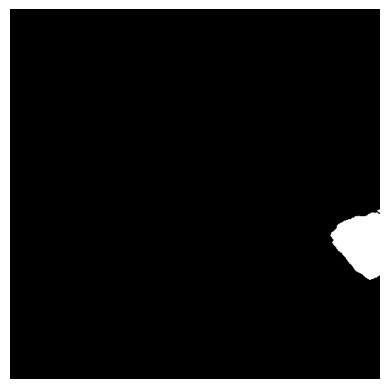

In [19]:
utils.show_image(mask[3])

In [20]:
mask = utils.binarize_mask(masks, sum_all_masks=True)

In [21]:
mask.shape

(500, 500)

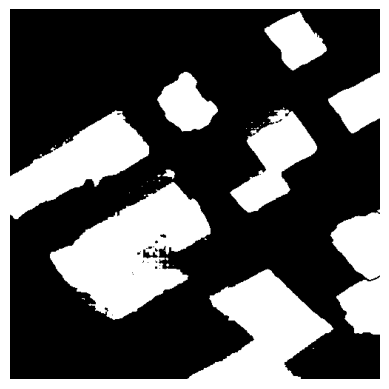

In [22]:
utils.show_image(mask)

### Mask Generation using Text Prompts

In this section, we will demonstrate how to utilize text prompts to generate masks using the SegMate toolkit. Text prompts provide a convenient way to specify the desired object for segmentation. By providing a text prompt along with threshold values, SAM can generate masks for the specified object within the input image.

To generate masks using text prompts, we will use the `segment()` method provided by the SegMate toolkit (`sm`). This method takes the input image and the text prompt as inputs and returns the corresponding segmentation masks.

In this example, text prompt is a tuple and consists of three elements: the text prompt itself, the bounding box threshold, and the text threshold. The box threshold and the text threshold control the segmentation sensitivity for the specified object.

Let's take a look at the code snippet:

In [60]:
cat_image = np.asarray(utils.load_image(image_path='../example/images/cat.jpg'))
building_image = np.asarray(utils.load_image(image_path='../example/images/building.png'))

In [61]:
cat_mask = sm.segment(image=np.array(cat_image), text_prompt=["cat", 0.20, 0.25])

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/content/SegMate/segmate/segmate.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_prompt = torch.tensor(boxes_prompt).to(self.device)


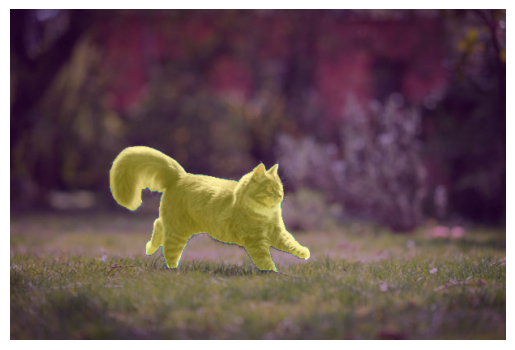

In [62]:
utils.show_masks(cat_image, cat_mask)

In [63]:
building_mask = sm.segment(image=np.array(building_image), text_prompt=["building", 0.20, 0.25])

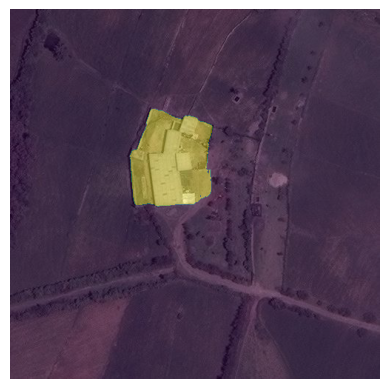

In [64]:
utils.show_masks(building_image, building_mask)

### Mask Generation using Points

In this section, we will demonstrate how to convert bounding boxes to center points using the `convert_bboxes2center_points()` function provided by the utility module (`utils`) in the SegMate toolkit. The function converts them to corresponding center points which can be used as prompts for point-based segmentation tasks.

To generate masks using point prompts, we will use the segment() method provided by the SegMate toolkit (sm). This method takes the input image and the point prompt as inputs and returns the corresponding segmentation masks.

Point prompts consist of point coordinates and point labels. Positive points indicate the presence of the object, while negative points represent the absence of the object. The converted center point coordinates can be used as positive points in the point prompt.

Let's take a look at the code snippet:

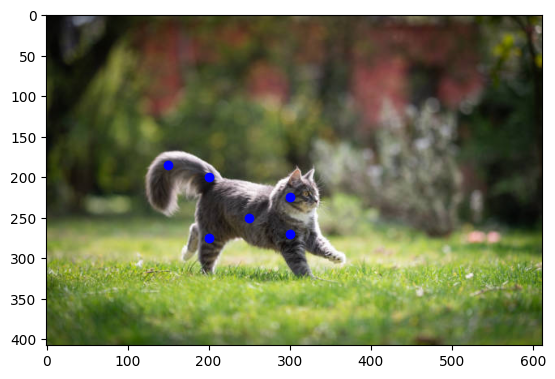

In [104]:
cat_point_coords = [(150, 185), (200, 200), (200, 275), (250, 250), (300, 225), (300, 270)]
cat_point_labels = [1, 1, 1, 1, 1, 1]
utils.show_points(cat_image, cat_point_coords, cat_point_labels)

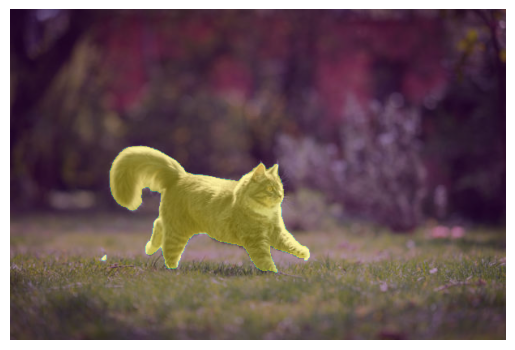

In [105]:
cat_mask = sm.segment(cat_image, points_prompt=[cat_point_coords, cat_point_labels])
utils.show_masks(cat_image, cat_mask)

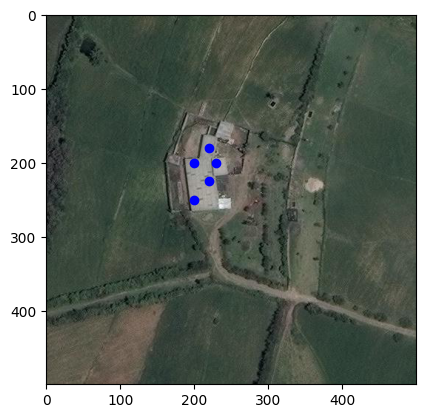

In [102]:
building_point_coords = [(200, 200), (200, 250), (220, 180), (230, 200), (220, 225)]
building_point_labels = [1, 1, 1, 1, 1,]
utils.show_points(building_image, building_point_coords, building_point_labels)

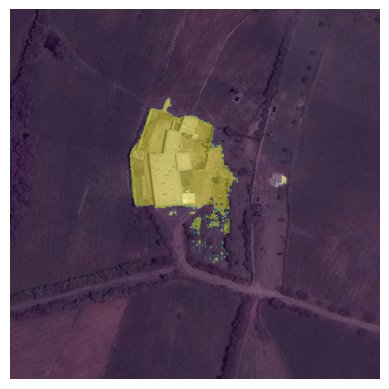

In [103]:
building_mask = sm.segment(building_image, points_prompt=[building_point_coords, building_point_labels])
utils.show_masks(building_image, building_mask)

### Fine-tuning on Building Image Segmentation Dataset

In this section, we will demonstrate how to create a PyTorch Dataset instance from the Building Image Segmentation (BIS) dataset and perform fine-tuning on this dataset using the SegMate toolkit.

To begin, we create an instance of the `BISDataset` class, which is a custom dataset class designed specifically for the Building Image Segmentation dataset. The `BISDataset` class takes the training subset of the BIS dataset (`dataset['train']`) as input, along with other parameters such as the preprocessing function (`preprocess`), the desired image size (`img_size`), and the device to be used (`device`).

Let's take a look at the code snippet:

In [65]:
dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

print(len(dataset['train']))

train_dataset = dataset['train']
print(len(train_dataset[:100]))

print(dataset['train'][0])
print()
print(dataset['train'][100])

print(dataset['train'][100]['width'])

print(type(dataset['train']))

6764
5
{'image_id': 1114, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F21DCD67280>, 'width': 500, 'height': 500, 'objects': {'id': [15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15554, 15555, 15556], 'area': [2018, 1130, 259, 3012, 260, 983, 4675, 1570, 1414, 13172, 5666, 5520], 'bbox': [[294.0, 398.0, 56.58000183105469, 35.66999816894531], [474.0, 259.0, 25.530000686645508, 44.290000915527344], [360.0, 455.0, 15.050000190734863, 17.209999084472656], [273.0, 272.0, 90.05999755859375, 33.45000076293945], [276.0, 435.0, 24.540000915527344, 10.600000381469727], [358.0, 316.0, 32.90999984741211, 29.8700008392334], [257.0, 310.0, 68.30999755859375, 68.44000244140625], [355.0, 268.0, 69.2699966430664, 22.670000076293945], [297.0, 447.0, 40.81999969482422, 34.63999938964844], [46.0, 267.0, 77.29000091552734, 170.42999267578125], [137.0, 269.0, 33.93000030517578, 167.00999450683594], [175.0, 268.0, 33.540000915527344, 164.5800018310547]], 'seg

In [41]:
for key, value in dataset['train'][0].items():

image_id 1114
image <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F22472B43A0>
width 500
height 500
objects {'id': [15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15554, 15555, 15556], 'area': [2018, 1130, 259, 3012, 260, 983, 4675, 1570, 1414, 13172, 5666, 5520], 'bbox': [[294.0, 398.0, 56.58000183105469, 35.66999816894531], [474.0, 259.0, 25.530000686645508, 44.290000915527344], [360.0, 455.0, 15.050000190734863, 17.209999084472656], [273.0, 272.0, 90.05999755859375, 33.45000076293945], [276.0, 435.0, 24.540000915527344, 10.600000381469727], [358.0, 316.0, 32.90999984741211, 29.8700008392334], [257.0, 310.0, 68.30999755859375, 68.44000244140625], [355.0, 268.0, 69.2699966430664, 22.670000076293945], [297.0, 447.0, 40.81999969482422, 34.63999938964844], [46.0, 267.0, 77.29000091552734, 170.42999267578125], [137.0, 269.0, 33.93000030517578, 167.00999450683594], [175.0, 268.0, 33.540000915527344, 164.5800018310547]], 'segmentation': [[[314.01998901

In [36]:
print(type(dataset['train'][0]))

<class 'dict'>


In [35]:
from datasets import Dataset, DatasetDict

custom_dataset = [dataset['train'][x] for x in range(0, 10)]

print(len(custom_dataset))

custom_dataset = Dataset.from_dict(custom_dataset)

# Convert image paths to PIL images
for sample in custom_dataset:
    sample['image'] = Image.open(sample['image'])

10


AttributeError: 'list' object has no attribute 'items'

In [15]:
train_dataset = dataset['train']
first_100_samples = train_dataset[:100]

print(len(first_100_samples))

5


In [ ]:
print 

In [83]:
print(len(random_samples))

10


In [5]:
from datasets import load_dataset
import random

# Load the dataset
dataset = load_dataset("keremberke/satellite-building-segmentation", "full")
train_data = dataset['train']

# train_data2 = [train_data[i] for i in range(len(train_data)) if train_data[i]['width'] == 512]

# print(train_data2)

# Set the number of samples you want (e.g., 10)
num_samples = 2

# Set a random seed for reproducibility
random.seed(42)  # You can use any integer value as the seed

# Get the indices of the samples to select
# num_samples_in_dataset = len(train_data)
# sample_indices = random.sample(range(num_samples_in_dataset), num_samples)

random_samples = list()

for i in range(100, 120):
    print(train_data[i]['width'])
    if train_data[i]['width'] == 500:
        print('TRUE')
        random_samples.append(train_data[i])

# # Use the indices to select the corresponding samples from the dataset
# random_samples = [train_data[i] for i in sample_indices]

# random_samples = []

# while len(random_samples) < 2:
#     print('Entered')
#     sample_index = random.sample(range(num_samples_in_dataset), 1)
#     print(train_data[sample_index]['width'])
#     if train_data[sample_index]['width'] == [500]: 
#         print('TRUE')
#         random_samples.append(train_data[sample_index])

# Now, random_samples contains the 10 randomly selected samples (same each time)
print(len(random_samples))

512
512
512
500
TRUE
512
500
TRUE
500
TRUE
500
TRUE
500
TRUE
500
TRUE
500
TRUE
512
512
512
500
TRUE
500
TRUE
500
TRUE
500
TRUE
500
TRUE
500
TRUE
13


In [6]:
print(type(random_samples))

<class 'list'>


In [7]:
from segmate.dataset import BISDataset


# print(len(dataset['train']))
# print(len(dataset['train'][1:30]))

# print(dataset['train'][1:3])

bis_dataset = BISDataset(dataset=random_samples,
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)

Next, we initiate the fine-tuning process using the fine_tune() method provided by the SegMate toolkit (sm). The `fine_tune()` method takes the training data `train_data`, learning rate `lr`, number of epochs `num_epochs`, and the original input size `original_input_size` as inputs.

Let's take a look at the code snippet:

In [8]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sm.sam.mask_decoder.parameters(), lr=1e-5)

In [10]:
sm.fine_tune(train_data=bis_dataset,
             original_input_size=500,
             criterion=criterion,
             optimizer=optimizer,
             num_epochs=25)

100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 0
Mean loss: 0.029615077154281046


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 1
Mean loss: 0.029787692420471173


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


EPOCH: 2
Mean loss: 0.02927476944974982


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


EPOCH: 3
Mean loss: 0.028550461651040956


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 4
Mean loss: 0.028731999811358176


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 5
Mean loss: 0.02967969199212698


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 6
Mean loss: 0.02966123052801077


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 7
Mean loss: 0.029626153552761443


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 8
Mean loss: 0.029219692178930227


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 9
Mean loss: 0.029467384796589613


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 10
Mean loss: 0.029566461471124336


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 11
Mean loss: 0.029357230541511223


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 12
Mean loss: 0.029278461570636585


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 13
Mean loss: 0.02923200003659496


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 14
Mean loss: 0.02911784589433899


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 15
Mean loss: 0.029163076613958065


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 16
Mean loss: 0.029485538494415008


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 17
Mean loss: 0.029865845572203398


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 18
Mean loss: 0.029695999916069783


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 19
Mean loss: 0.0318076923632851


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 20
Mean loss: 0.03272676901318706


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 21
Mean loss: 0.033200615228941806


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 22
Mean loss: 0.03319446130010944


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


EPOCH: 23
Mean loss: 0.033188922939678796


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]

EPOCH: 24
Mean loss: 0.03362676941861327
